# Lab 3: Inference and Capital Punishment, Part 1

Welcome to Lab 3! Over the next two labs, you will investigate the data relevant to a hotly debated social issue: the possible influence of capital punishment (the death penalty) on murder rates in the United States.

Lab 3 is part 1 of the investigation. Lab 4 is part 2 of the investigation. Lab 4 will be released next week.

By the end of lab 4, you should know how to:

1. Test whether observed data appears to be a random sample from a distribution.
2. Analyze a natural experiment.
3. Implement and interpret a sign test.
4. Create a function to run a general hypothesis test.
5. Analyze visualizations and draw conclusions from them.

**Advice.** Develop your answers incrementally. To perform a complicated table manipulation, break it up into steps, perform each step on a different line, give a new name to each result, and check that each intermediate result is what you expect by displaying it. You can add additional names or functions to the provided cells in order to organize your work. 

To get started, load `datascience`, `numpy`, `plots`, and `okgrade`.

In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from okgrade import grade

## Overview

Punishment for crime has many [philosophical justifications](http://plato.stanford.edu/entries/punishment/#ThePun).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute some people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is: Does instituting a death penalty as a punishment for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

Here is a road map for part 1:

1. In section 1, we'll visualize and explore the main dataset we'll be using.
2. In section 2, we'll test a hypothesis.

#### Data

The main data source for this project comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

In [65]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


## 1. Murder rates

The `murder_rates` table isn't enough to demonstrate an *association* between crimes and punishments. We would like to check for an association between murder rates and the existence of capital punishment, for each pair of a state and a year.

**Question 1.1.** <br/>What additional information will we need before we can check for that association? Assign `extra_info` to a Python list (i.e. [#] or [#, #, ...]) containing the number(s) for all of the additional facts below that we *require* in order to check for association.

1) What year(s) the death penalty was introduced in each state (if any).

2) Day to day data about when murders occurred.

3) What year(s) the death penalty was abolished in each state (if any).

4) Rates of other crimes in each state.

In [ ]:
extra_info = [1,3]

Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. Let's plot the murder rate trends for a few states, just to see the variety.

**Question 1.2.** <br/>Draw a line plot with years on the horizontal axis and murder rates on the 
vertical axis. Include two lines: one for Alaska murder rates and one for Minnesota murder rates. Create this plot using a single call, `ak_mn.plot('Year')`.

*Hint*: To create two lines, you will need create the table `ak_mn` with two columns of murder rates, in addition to a column of years. This table will have the following structure:

| Year | Murder rate in Alaska | Murder rate in Minnesota |
|------|-----------------------|--------------------------|
| 1960 | 10.2                  | 1.2                      |
| 1961 | 11.5                  | 1                        |
| 1962 | 4.5                   | 0.9                      |

<center>... (41 rows omitted)</center>

In [ ]:
# The next lines are provided for you.  They create a table
# containing only the Alaska information and one containing
# only the Minnesota information.
ak = murder_rates.where('State', 'Alaska').drop('State', 'Population').relabeled(1, 'Murder rate in Alaska')
mn = murder_rates.where('State', 'Minnesota').drop('State', 'Population').relabeled(1, 'Murder rate in Minnesota')

# Fill in this line to make a table like the one pictured above
ak_mn = ak.select(0,1).with_column('Murder rate in Minnesota',mn.column(1))
ak_mn

In [ ]:
# Draw your line plot here
ak_mn.plot(0)

What about the murder rates of other states? Say, for example, California and New York? Fill in the cell below to plot the murder rates of different pairs of states. **Note:** this should use similar code to question 1.2, with only the variable names changed. The cell below will not be graded, but it creates a cool interactive module!

In [ ]:
# Compare the murder rates of any two states by filling in the blanks below

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def state(state1, state2):
    state1_table = murder_rates.where('State', state1).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state1))
    state2_table = murder_rates.where('State', state2).drop('State', 'Population').relabeled(1, 'Murder rate in {}'.format(state2))
    s1_s2 = state1_table.select(0,1).with_column('Murder rate in Minnesota',state2_table.column(1))
    s1_s2.plot('Year')
    plots.show()

states_array = murder_rates.group('State').column('State')

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
            )

**Question 1.3.** <br/>Implement the function `most_murderous`, which takes a year (an integer) as its argument. It does two things:
1. It draws a horizontal bar chart of the 5 states that had the highest murder rates in that year.
2. It returns an array of the names of these states in order of *increasing* murder rate.

Assume that the argument is a year in `murder_rates`. You do not need to check that it is.

In [ ]:
def most_murderous(year):
    # Assign most to a table of the most murderous states this year in ascending order.
    data_for_year = murder_rates.where(1,are.equal_to(year)).drop(2)
    sorted_data = data_for_year.sort(2,descending=True)
    top_5 = sorted_data.take(np.arange(5))
    top_5.barh('State', 'Murder Rate')
    return top_5.column('State')

most_murderous(1990) # California, Mississippi, ..., 


**Question 1.4.** <br/>How many more people were murdered in California in 1988 than in 1975? Assign `ca_change` to the answer.

*Hint*: Make sure you understand how murder rate is calculated. Recall the formula given at the beginning of the project:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

Feel free to define new variables and use additional lines to compute your answer. However, **make sure not to change any existing variable names**.

In [ ]:
ca = murder_rates.where('State', are.equal_to('California'))
ca_change = ((ca.where('Year',are.equal_to(1975)).column(3).item(0)/100000)*(ca.where('Year',are.equal_to(1975)).column(2).item(0))) 
cal =((ca.where('Year',are.equal_to(1988)).column(3).item(0)/100000)*(ca.where('Year',are.equal_to(1988)).column(2).item(0))) 
np.round(cal-ca_change)

# 2. Changes in Murder Rates

In this section, we'll see how to test this null hypothesis: "For a set of U.S. states, the murder rate was equally likely to go up or down each year."

Murder rates vary widely across states and years, presumably due to the vast array of differences among states and across US history. Rather than attempting to analyze rates themselves, here we will restrict our analysis to whether or not murder rates increased or decreased over certain time spans. **We will not concern ourselves with how much rates increased or decreased; only the direction of the changes** - whether they increased or decreased.

The `np.diff` function takes an array of values and computes the differences between adjacent items of a list or array as such:

    [item 1 - item 0 , item 2 - item 1 , item 3 - item 2, ...]

Instead, we may wish to compute the difference between items that are two positions apart. For example, given a 5-element array, we may want:

    [item 2 - item 0 , item 3 - item 1 , item 4 - item 2]
    
The `diff_n` function below computes this result. Don't worry if the implementation uses unfamiliar features of Python, as long as you understand its behavior.

In [ ]:
def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

diff_n(make_array(1, 10, 100, 1000, 10000), 2)

**Question 2.1.** <br/>Implement the function `two_year_changes` that takes an array of murder rates for a state, ordered by increasing year. For all two-year periods (e.g., from 1960 to 1962), it computes and returns **the number of increases minus the number of decreases.**

For example, the array `r = make_array(10, 7, 12, 9, 13, 9, 11)` contains 3 increases (10 to 12, 7 to 9, and 12 to 13), 1 decrease (13 to 11), and 1 change that is neither an increase or decrease (9 to 9). Therefore, `two_year_changes(r)` would return 2, the difference between 3 increases and 1 decrease.

*Hint*: Consider using the `diff_n` function.

In [70]:
def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    increase = 0
    decrease = 0
    for i in np.arange(np.count_nonzero(rates)-2):
        if rates.item(i)>rates.item(i+2):
            increase = increase+1
        elif rates.item(i)<rates.item(i+2):
            decrease = decrease + 1
        
    return(decrease-increase)

print('Alaska:',    two_year_changes(ak.column('Murder rate in Alaska')))
print('Minnesota:', two_year_changes(mn.column('Murder rate in Minnesota')))

Alaska: -5
Minnesota: 6


We can use `two_year_changes` to summarize whether rates are mostly increasing or decreasing over time for some state or group of states. Let's see how it varies across the 50 US states.

**Question 2.2.** <br/>Assign `changes_by_state` to a table with one row per state that has two columns: the `State` name and the `Murder Rate two_year_changes` statistic computed across all years in our data set for that state.  Its first 2 rows should look like this:

|State|Murder Rate two_year_changes|
|-|-|
|Alabama|-6|
|Alaska|-5||

<center>... (48 rows omitted)</center>


In [87]:
states = murder_rates.sort(0,distinct=True).column(0)
twoYear = make_array()
for p in np.arange(50):
    murder = two_year_changes(murder_rates.take(np.arange(44*p,44*(1+p))).column(3))
    twoYear = np.append(twoYear,murder)

changes_by_state = Table().with_columns('State',states,'Murder Rate two_year_changes',twoYear)
changes_by_state

State,Murder Rate two_year_changes
Alabama,-6
Alaska,-5
Arizona,1
Arkansas,-1
California,17
Colorado,-4
Connecticut,4
Delaware,-3
Florida,-6
Georgia,-3


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


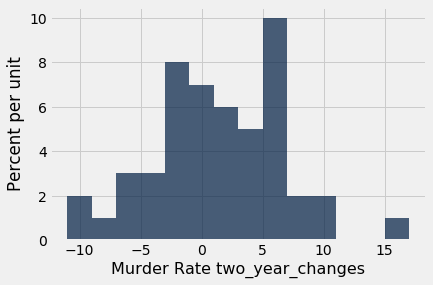

In [88]:
# Here is a histogram of the two-year changes for the states.
# Since there are 50 states, each state contributes 2% to one bar.
changes_by_state.hist("Murder Rate two_year_changes", bins=np.arange(-11, 19, 2))

Some states have more increases than decreases (a positive change), while some have more decreases than increases (a negative change). 

**Question 2.3.** <br/>Assign `total_changes` to the total increases minus the total decreases for all two-year periods and all states in our data set. For example, if the murder rate in Ohio went up 23 times and fell 17 times, the total change for Ohio would be 6. We want the total value for all the states together.

In [90]:
total_changes = np.sum(changes_by_state.column(1))
print('Total increases minus total decreases, across all states and years:', total_changes)

Total increases minus total decreases, across all states and years: 45.0


"More increases than decreases," one person exclaims, "Murder rates tend to go up across two-year periods. What dire times we live in."

"Not so fast," another person replies, "Even if murder rates just moved up and down uniformly at random, there would be some difference between the increases and decreases. There were a lot of states and a lot of years, so there were many chances for changes to happen. If state murder rates increase and decrease at random with equal probability, perhaps this difference was simply due to chance!"

**Question 2.4.** <br/>What is the total number of distinct pairs of a state and a two-year period? Assign `num_changes` to this value.

For example, Alaska during 1968 to 1970 would count as one distinct pair. Considering all states and all possible two-year periods, how many such pairs are there in total? 

In [96]:
num_changes = 50*(42)
num_changes

2100

We now have enough information to perform a hypothesis test.

> **Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

Murder rates can be more likely to go up or more likely to go down. Since we observed 45 more increases than decreases for all two year periods in our dataset, we formulate an alternative hypothesis in accordance with our suspicion:

> **Alternative Hypothesis**: State murder rates are more likely to increase over two-year periods.

If we had observed more decreases than increases, our alternative hypothesis would have been defined accordingly (that state murder rates are more likely to *decrease*). This is typical in statistical testing - we first observe a trend in the data and then run a hypothesis test to confirm or reject that trend.

*Technical note*: These changes in murder rates are not random samples from any population. They describe all murders in all states over all recent years. However, we can imagine that history could have been different, and that the observed changes are the values observed in only one possible world: the one that happened to occur. In this sense, we can evaluate whether the observed "total increases minus total decreases" is consistent with a hypothesis that increases and decreases are drawn at random from a uniform distribution.

*Important requirements for our test statistic:* We want to choose a test statistic for which large positive values are evidence in favor of the alternative hypothesis, and other values are evidence in favor of the null hypothesis. This is because once we've determined the direction of our alternative hypothesis, we only care about the tail in that direction. If, for example, our p-value cutoff was 5%, we'd check to see if our observed test statistic fell within the largest 5% of values in our null hypothesis distribution. 

Our test statistic should depend only on whether murder rates increased or decreased, not on the size of any change. Thus we choose:

> **Test Statistic**: The number of increases minus the number of decreases

The cell below samples increases and decreases at random from a uniform distribution 100 times. The final column of the resulting table gives the number of increases and decreases that resulted from sampling in this way. **Using `sample_from_distribution` is faster than using `sample` followed by `group` to compute the same result.**

In [100]:
uniform = Table().with_columns(
    "Change", make_array('Increase', 'Decrease'),
    "Chance", make_array(0.5,        0.5))
uniform.sample_from_distribution('Chance', 100)

Change,Chance,Chance sample
Increase,0.5,44
Decrease,0.5,56


**Question 2.5.** <br/>Complete the simulation below, which samples `num_changes` increases/decreases at random many times and forms an empirical distribution of your test statistic under the null hypothesis.  Your job is to
* fill in the function `simulate_under_null`, which simulates a single sample under the null hypothesis, and
* fill in its argument when it's called below.

In [138]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of our
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    sample = uniform.sample_from_distribution('Chance',num_chances_to_change)
    return np.diff(sample.column(2))*-1

uniform_samples = make_array()
for i in np.arange(5000):
    uniform_samples = np.append(uniform_samples, simulate_under_null(10000))

simulated_changes = Table().with_column('Test statistic under null', uniform_samples)
simulated_changes

Test statistic under null
98
-112
16
144
-38
34
44
-26
54
-38


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


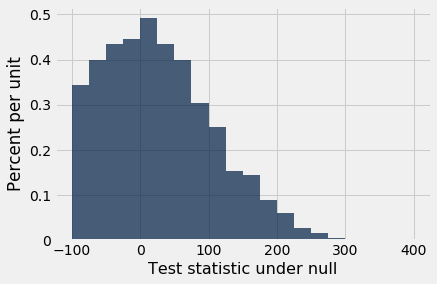

In [139]:
# Run this cell to visualize the empirical distribution of 
# the test statistic under the null hypothesis.
simulated_changes.hist(0, bins=np.arange(-100, 400+25, 25))

**Question 2.6.** Looking at this histogram, draw a conclusion about whether murder rates basically increase as often as they decrease. (Remember that we're only concerned with the *postive direction* because it supports our alternative hypothesis.) You **do not** need to compute a P-value for this question.

First, set `which_side` to `"Right"` or `"Left"` depending on which side of the histogram you need to look at to make your conclusion. 

Then, set `reject_null` to `True` if rates increase more than they decrease, and we can reject the null hypothesis. Set `reject_null` to `False` if the observed difference is typical under the null hypothesis.

In [ ]:
which_side = 'Right'
reject_null = False

## Submission

You're finished with lab 3! We'll pick off from here next week in lab 4 to finish our investigation of capital punishment in the United States.

In order to successfully submit your assignment, follow these steps...
- **IMPORTANT** Before you do anything, **Save and Checkpoint** from the `File` menu. Please do this first before running the cell below,
- **run all the tests and verify that they all pass** (the next cell has a shortcut for that), 
- **Review the notebook one last time, we will be grading the final state of your notebook** If you make any changes, please **Save and Checkpoint** again.